# RNN

*Recurent Neural Network*

再帰型ニューラルネットワーク。  
再帰的な構造を持つニューラルネットワークで、可変長の時系列データを扱うことが得意。

<u>2章: 深層学習を用いた言語モデル</u>では、深層学習を活用して、ある単語から次の単語を予測するモデルを作成した。しかし、これでは文脈を考慮できない。具体的には、2つ以上前の単語を考慮した予測が出来ない。  
RNNを用いることで、文脈を考慮した予測が可能になる。

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from dlprog import train_progress

In [2]:
prog = train_progress()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')


---

## RNNの構造

RNNはある時間$t$の入力$x_t$に対して以下のような演算を行い、出力値$h_t$を決定する。

$$
h_t = \mathrm{tanh}(W_x x_t + b_x + W_h h_{t-1} + b_h)
$$

演算の内部で前の時間の出力値$h_{t-1}$を参照していることが分かる。  
演算内容はシンプルに捉えることができて、入力$x_t$と前の時間の出力$h_{t-1}$をそれぞれ線形変換し、それらの和を活性化関数$\mathrm{tanh}$に通しているだけ。線形変換に必要な重みとバイアスが2つずつあるので、パラメータは合計4つ。

実装してみるとこんな感じ。

In [3]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc_input = nn.Linear(input_size, output_size)
        self.fc_output = nn.Linear(output_size, output_size)

    def forward(self, x, h):
        z = self.fc_input(x) + self.fc_output(h)
        h = F.tanh(z)
        return h

### 推論

推論の流れを見てみる。

まず適当なパラメータで出力の初期値$h_0$と初めの入力$x_1$を定義する。$h_0$は0ベクトルで良い。

In [4]:
batch_size, input_size, hidden_size = 2, 3, 4
x1 = torch.randn(batch_size, input_size)
h0 = torch.zeros(batch_size, hidden_size)

rnn = RNN(input_size, hidden_size)
h1 = rnn(x1, h0)
h1

tensor([[-0.8084,  0.3854, -0.3857, -0.7751],
        [-0.1904,  0.4758, -0.5513, -0.9322]], grad_fn=<TanhBackward0>)

この$h_1$を参照して、次の時間の入力$x_2$に対する出力$h_2$を決定する。

In [5]:
x2 = torch.randn(batch_size, input_size)
h2 = rnn(x2, h1)
h2

tensor([[-0.9149,  0.5173, -0.0491, -0.8114],
        [-0.2597,  0.9164, -0.5752, -0.4781]], grad_fn=<TanhBackward0>)

これがRNNの推論の流れである。実践的な例は後程。


---

## PyTorchでの実装

PyTorchにはRNNを実装するためのクラスが用意されている。軽く紹介する。

### `torch.nn.RNNCell`

RNNの一つの時間の演算を行うクラス。↑で実装したものと同じ。  
[RNNCell — PyTorch 2.0 documentation](https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html)

In [6]:
batch_size, input_size, hidden_size = 2, 3, 4

rnn = nn.RNNCell(input_size, hidden_size)
for params in rnn.parameters():
    print(params, '\n')

Parameter containing:
tensor([[ 0.0296, -0.2979, -0.3870],
        [-0.3157, -0.2930,  0.0757],
        [ 0.2960, -0.2860,  0.3643],
        [-0.2431,  0.3487, -0.2138]], requires_grad=True) 

Parameter containing:
tensor([[-0.4569, -0.2122,  0.4331,  0.0307],
        [ 0.1556, -0.2945, -0.1549, -0.0089],
        [ 0.4429, -0.2736,  0.2788, -0.1972],
        [-0.4256,  0.4540,  0.3017, -0.1940]], requires_grad=True) 

Parameter containing:
tensor([ 0.4262, -0.4771, -0.4876, -0.2211], requires_grad=True) 

Parameter containing:
tensor([ 0.3696, -0.4244,  0.3633,  0.4644], requires_grad=True) 



パラメータが4つ。

In [7]:
x1 = torch.randn(batch_size, input_size)
rnn(x1)

tensor([[ 0.8440, -0.7729, -0.7073,  0.6563],
        [ 0.6060, -0.9268, -0.0587,  0.2554]], grad_fn=<TanhBackward0>)

$h$を入力しなかった場合は勝手に0ベクトルになる。

### `torch.nn.RNN`

全ての時間の演算をまとめて行うクラス。  
[RNN — PyTorch 2.0 documentation](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)



In [8]:
batch_size, input_size, hidden_size, seq_length = 2, 3, 4, 5
rnn = nn.RNN(input_size, hidden_size, batch_first=True)

x = torch.randn(batch_size, seq_length, input_size)
y, h = rnn(x)
y.shape

torch.Size([2, 5, 4])

バッチごとに全ての時間の隠れ状態が出力される。  
また`h`には最後の時間の隠れ状態が出力される。

In [9]:
y[:, -1] == h

tensor([[[True, True, True, True],
         [True, True, True, True]]])

In [10]:
h.shape

torch.Size([1, 2, 4])

初めに次元が1つ追加されるのは仕様。


---

## sin波の生成

与えられたsin波から続きを生成するモデルを作ろう。

### データセット

ノイズの加わったsin波をデータセットとして用意する。

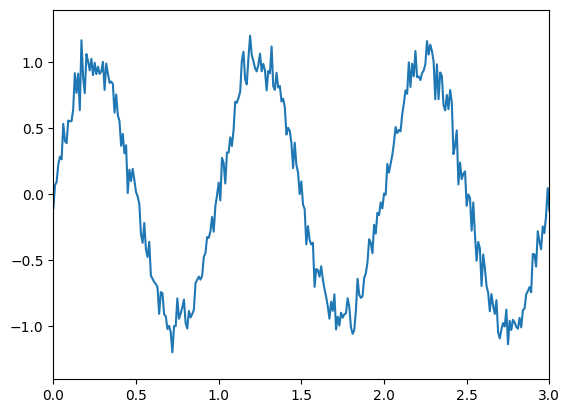

In [11]:
freq, sr, n_samples = 1, 100, 10000
t = torch.arange(0, n_samples / sr, 1 / sr)
noise = torch.randn(n_samples) * 0.1
sin = torch.sin(2 * torch.pi * freq * t)
seq = sin + noise
plt.plot(t, seq)
plt.xlim(0, 3);


### 通常のNN

比較用に、まずは通常のNNで学習させてみよう。

n個の値から次の一つの値を予測するモデルを作る。

In [12]:
class NN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        return self.net(x)

In [13]:
input_size = 50 # n=50
hidden_size = 100
model = NN(input_size, hidden_size)
optimizer = optim.Adam(model.parameters())

次に学習データを用意する。  
連続したn個の値をそれに続く一つの値をペアとして用意する。

In [14]:
class SinDataset(Dataset):
    def __init__(self, seq):
        self.seq = seq
        self.n_data = n_samples - input_size

    def __getitem__(self, idx):
        seq = self.seq[idx:idx + input_size + 1]
        return seq[:-1], seq[-1]

    def __len__(self):
        return self.n_data

batch_size = 64
dataset = SinDataset(seq)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

学習させてみよう。

In [15]:
def train(model, optimizer, n_epochs):
    model.train()
    prog.start(n_iter=len(dataloader), n_epochs=n_epochs)
    for _ in range(n_epochs):
        for x, y in dataloader:
            optimizer.zero_grad()
            pred = model(x)
            loss = F.mse_loss(pred.ravel(), y)
            loss.backward()
            optimizer.step()
            prog.update(loss.item())

In [16]:
train(model, optimizer, 5)

1/5: ######################################## 100% [00:00:00.32] loss: 0.03026 
2/5: ######################################## 100% [00:00:00.33] loss: 0.01104 
3/5: ######################################## 100% [00:00:00.31] loss: 0.01096 
4/5: ######################################## 100% [00:00:00.31] loss: 0.01076 
5/5: ######################################## 100% [00:00:00.31] loss: 0.01075 


予測してみよう。  
予測した値を含めた直近n個の値を入力し、次の値を予測する。これを繰り返す。初めのn個の値は学習データから取得する。

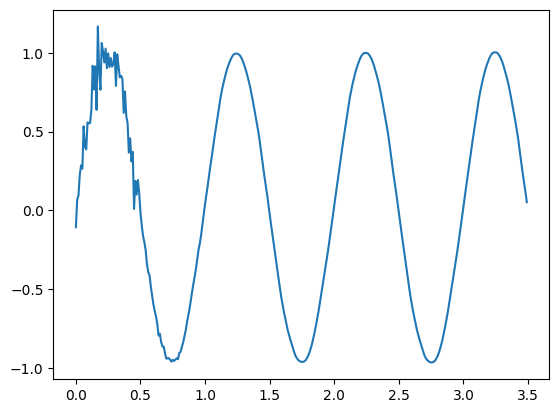

In [17]:
pred_seq = seq[:input_size] # 初めのn個
n_preds = 3 * sr # 予測する回数
model.eval()
for _ in range(n_preds):
    with torch.no_grad():
        x = pred_seq[-input_size:] # 直近のn個
        pred = model(x) # 予測
        pred_seq = torch.cat([pred_seq, pred]) # 予測結果を追加
plt.plot(t[:len(pred_seq)], pred_seq);

初めのn個の値から、それに続くsin波を予測することが出来た。

### RNN

では、今度はRNNを用いて学習させてみよう。

まずはモデルを作る。基本的に、RNNそのものを一つのモデル（NN）として扱うことはない。RNNはNNの中の一つの層として扱う。  
ちなみに、RNNが組み込まれたNNをRNNと呼ぶこともある。混乱を避けるために、以下では層としてのRNNはRNN層と呼ぶこととする（モデルとしてのRNNはそのままRNNと呼ぶ）。

ある時間$t$におけるRNN層は、前の層からの出力$z_t$と前の時間のRNN層の出力$h_{t-1}$を受け取り、$h_t$を出力する。そしてこのRNN層からの出力$h_t$を適当な線形層などに入力することで、最終的な出力$y_t$を生成する。

$h_t$は外から直接観測されることがないため、潜在変数や隠れ状態と表現される。変数名に$y$ではなく$h$を使っている理由がそこにある（隠れる=hide）。

では作っていこう。RNN層と線形層で作る。

RNNの時間ごとの入出力（RNN層の入力と線形層の出力）の形状は、シーケンスを構成する各時間のデータと同じ。sin波の各時間は一つの値なので、入出力も一つの値（1次元ベクトル（スカラー））。一つの値を受け取って一つの値を出力するモデルということ。

In [18]:
class RNN(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.rnn = nn.RNN(1, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x, h=None):
        y, h = self.rnn(x, h)
        y = self.fc(y)
        return y, h

In [19]:
hidden_size = 128
model = RNN(hidden_size)
optimizer = optim.Adam(model.parameters())

このRNNが出力した一つの値を次の時間の入力として与え、また出力を得る。  
これを繰り返して適切なsin波が生成されるように学習を行う。

では次に学習データを用意する。

まず、データセットから適当な長さのシーケンスを取り出したとする。この最初の値をRNNに入力し、再帰的に後続の値を予測させたとき、データセットから取り出したサンプルと同じシーケンスが出力されて欲しいわけだ。  
では、どのような（入力と正解の）ペアを作れば良いだろうか。

まず考えられるのは、最初の一つを入力、それ以降を正解とするペア。最初の一つを入力してそれに続く（サンプルと同じ長さの）シーケンスを予測させ、正解との誤差が小さくなるように学習させる。  
しかしこの手法は学習の安定性等のデメリットからあまり使われていない。特に言語モデルの場合、出力（確率分布）を入力（単語）に変換する際にサンプリングを挟むことから逆伝播が繋がらなくなり、デメリットがより顕著に表れる、と私は考えている。やったことないから知らん。

次にこんな手法を考える。サンプルの最初の一つをRNNに入力し、次の値を予測させる。そして、この予測値を次の入力とするのではなく、サンプルから次の値を取り出してそれを入力する。サンプルから取り出した次の値とは、いわば正しい値である。  
このように、RNNの学習時にRNN自身の出力ではなく正解値を入力として用いる手法を**教師強制**と呼ぶ。この手法の方が安定すると言われている。

今回は教師強制を用いて学習を行う。そのための学習データを作る。

入力の長さを適当に定め、データセットからその長さ分データを取り出す。取り出したものを入力、それを一つずらしたものを正解とする。個のペアを学習データとすれば、教師強制で学習が行えるね。

In [20]:
class SinDataset(Dataset):
    def __init__(self, seq, input_length):
        self.seq = seq
        self.input_length = input_length
        self.n_data = n_samples - input_length

    def __getitem__(self, idx):
        seq = self.seq[idx:idx + self.input_length]
        return seq[:-1], seq[1:] # 入力とそれを一つずらしたもの

    def __len__(self):
        return self.n_data

batch_size = 64
input_length = 200
dataset = SinDataset(seq, input_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

では学習させよう。MSEが小さくなるように。

In [21]:
n_epochs = 5
model.train()
prog.start(n_iter=len(dataloader), n_epochs=n_epochs)
for _ in range(n_epochs):
    for x, y in dataloader:
        optimizer.zero_grad()
        x = x.unsqueeze(-1)
        y = y.unsqueeze(-1)
        pred, _ = model(x)
        loss = F.mse_loss(pred, y)
        loss.backward()
        optimizer.step()
        prog.update(loss.item())

1/5:                                            1% [00:00:00.11] loss: 0.52734 

1/5: ######################################## 100% [00:00:04.85] loss: 0.04318 
2/5: ######################################## 100% [00:00:04.93] loss: 0.01519 
3/5: ######################################## 100% [00:00:04.83] loss: 0.01477 
4/5: ######################################## 100% [00:00:04.80] loss: 0.01455 
5/5: ######################################## 100% [00:00:04.84] loss: 0.01465 


最後にsin波を生成させてみよう。  
初めに、学習データから適当に得た入力を用いて隠れ状態を初期化する。以降は、直前に予測した値から次の値を予測する、を繰り返す。

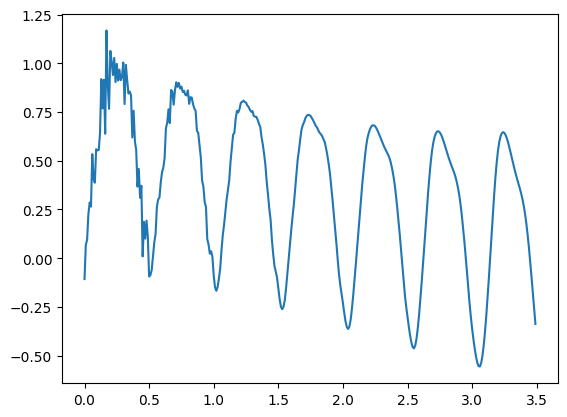

In [22]:
pred_seq = seq[:input_size] # 学習データから得た初めのn個
_, h = model(pred_seq.unsqueeze(-1)) # 隠れ状態の初期化

n_preds = 3 * sr
model.eval()
for _ in range(n_preds):
    with torch.no_grad():
        x = pred_seq[-input_size].reshape(1, 1) # 直近の1個
        (pred,), h = model(x, h) # 予測
        pred_seq = torch.cat([pred_seq, pred]) # 予測結果を追加
plt.plot(t[:len(pred_seq)], pred_seq);

一応できた。でも下手だね。まあ、そんなときもあるよ。

通常のNNでは、直前に生成したデータのみを用いて次のデータを予測する。この、外側から見えるデータには多くの情報を含めることが出来ない。  
実際、今回例に用いたsin波では小数一つ分の情報しか含まれない。言語モデルの場合は一単語分の情報。「直前のデータしか参照できないから文脈を考慮することは出来ない」というのは、「直前のデータに文脈の情報を載せることが出来ないから」と説明できる。

RNNの場合、予測には、直前に生成したデータだけでなく、隠れ状態も用いる。

隠れ状態には高次元の連続的なベクトルを用いるため、生成するデータよりも多くの情報量を含めることが可能。その**直前にモデルが出力した多くの情報（隠れ状態）を参照できる枠組みをモデルに提供**することで、隠れ状態に文脈の情報を載せた、文脈を考慮した予測が可能になると**期待**できる。

こういった、「こんな枠組み（アーキテクチャ）でモデルを作ればこう動いてくれるだろう」という期待は、この先説明する多くのアーキテクチャの出発点となる。それらの有名なアーキテクチャは、そういった期待に見事応えてくれたものと見られる。